In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools

In [20]:
df_train = pd.read_csv('./anomaly_detection_dataset_2022/trainset.csv')
df_anomaly = pd.read_csv('./anomaly_detection_dataset_2022/anomaly_testset2.csv')

df_train['created_at'] = pd.to_datetime(df_train['created_at'])
df_anomaly['created_at'] = pd.to_datetime(df_anomaly['created_at'])

In [21]:
# insert anomalous data into df_anomaly
rand_row = 100
df_anomaly.at[rand_row, 'Air2_0013A20041C54517/temp'] = 60.0

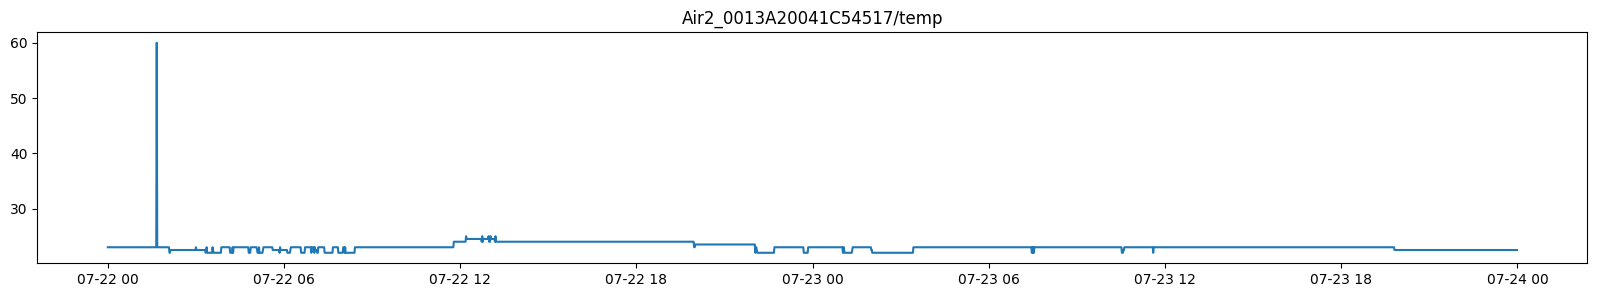

In [22]:
plt.figure(figsize=(20, 3))
plt.title('Air2_0013A20041C54517/temp')
plt.plot(df_anomaly['created_at'], df_anomaly['Air2_0013A20041C54517/temp'])
plt.show()

In [23]:
df_train = df_train.drop(columns=['created_at'])
df_anomaly = df_anomaly.drop(columns=['created_at', 'scene', 'label'])

In [24]:
# fit scaler, fitted on the train data
scaler = StandardScaler()
scaler.fit(df_train)
scaled_train_data = scaler.transform(df_train)

# fit k-means, fitted on the scaled train data
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_train_data)

# fit PCA, fitted on the scaled train data
pca = PCA(n_components=2)
pca.fit(scaled_train_data)

PCA(n_components=2)

In [25]:
# cluster the data sets
scaled_train_data = scaler.transform(df_train)
train_clusters = kmeans.predict(scaled_train_data)
df_train['cluster'] = train_clusters

scaled_anomalous_data = scaler.transform(df_anomaly)
anomalous_clusters = kmeans.predict(scaled_anomalous_data)
df_anomaly['cluster'] = anomalous_clusters

In [26]:
pca_train_data = pca.transform(scaled_train_data)
pca_anomaly_data = pca.transform(scaled_anomalous_data)



In [27]:
train_clusters.shape

(45395,)

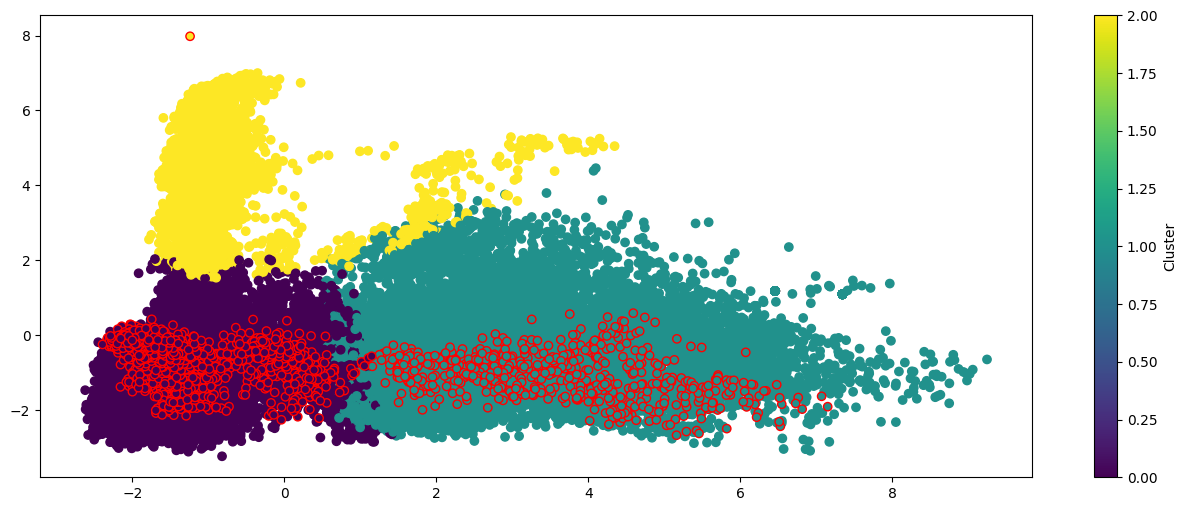

In [28]:
plt.figure(figsize=(16,6))
plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c=train_clusters, cmap='viridis', edgecolors=None, alpha=1)
plt.scatter(pca_anomaly_data[:, 0], pca_anomaly_data[:, 1], c=anomalous_clusters, cmap='viridis', edgecolors='red')
plt.colorbar(label='Cluster')
plt.show()

In [29]:
# detect anomaly using distances from clusters

# for each point, compute distance to cluster
train_distances = kmeans.transform(scaled_train_data)
anomalous_distances = kmeans.transform(scaled_anomalous_data)

print('train_distances:\n', train_distances)

df_train['distance_to_cluster'] = np.min(train_distances, axis=1)
df_anomaly['distance_to_cluster'] = np.min(anomalous_distances, axis=1)

print('distance_to_cluster:\n', df_train['distance_to_cluster'].head())

# compute thresholds for each cluster
thresholds = {}
for cluster in range(kmeans.n_clusters):
    # get distances for cluster
    cluster_distances = df_train[df_train['cluster'] == cluster]['distance_to_cluster']

    # find threshold for the cluster
    thresholds[cluster] = np.percentile(cluster_distances, 99)

print(thresholds)

train_distances:
 [[6.94709657 4.45822715 7.9958486 ]
 [8.8320547  6.48759311 9.77063021]
 [6.92797217 4.51360869 8.05263277]
 ...
 [1.69538832 5.38250814 4.91125212]
 [2.64077804 5.46487197 5.43452551]
 [1.9786541  5.68660522 5.13825554]]
distance_to_cluster:
 0    4.458227
1    6.487593
2    4.513609
3    4.206263
4    5.344401
Name: distance_to_cluster, dtype: float64
{0: 5.445923233792707, 1: 8.548252307844628, 2: 5.428281558291074}


In [30]:
detected_data = df_anomaly[
    df_anomaly.apply(lambda row: row['distance_to_cluster'] > thresholds[row['cluster']], axis=1)
]

In [31]:
detected_data

,Air1_0013A20041A77E1F/dust,Air1_0013A20041A77E1F/humid,Air1_0013A20041A77E1F/temp,Air2_0013A20041C54517/dust,Air2_0013A20041C54517/humid,Air2_0013A20041C54517/temp,Air3_0013A20041C53D79/humid,Air3_0013A20041C53D79/temp,CO2Sensor2_0013A20041C37EB3/CO2,CO2Sensor3_0013A20041C53D7D/CO2,Move1_0013A20041C53D71/movement_value,Sound1_0013A20041C53DE3/brightness,Sound1_0013A20041C53DE3/sound,Sound2_0013A20041C53CC2/brightness,Sound2_0013A20041C53CC2/sound,Sound3_0013A20041C53DA3/brightness,Sound3_0013A20041C53DA3/sound,human_detector_D8C0A69B3239/human_num,cluster,distance_to_cluster
5,5.5,44.0,26.0,9.0,50.5,23.0,49.0,23.0,543.0,410.0,1.0,6.0,148.0,69.5,171.0,22.0,339.0,1.0,0,5.812093
24,7.0,45.0,26.0,8.5,50.5,23.0,49.0,23.0,533.0,411.0,1.0,6.0,140.0,68.0,146.0,20.5,329.0,1.0,0,5.803209
28,7.0,44.5,26.0,7.0,50.0,23.0,48.0,23.0,527.5,408.0,1.0,8.0,154.0,67.0,144.0,21.0,290.0,1.0,0,5.731048
39,8.0,44.5,26.0,8.0,51.0,23.0,49.0,23.0,532.0,411.0,1.0,6.5,162.0,66.5,147.0,21.0,287.0,1.0,0,5.806426
67,11.0,44.0,26.0,9.0,51.0,23.0,49.0,23.0,515.0,406.5,1.0,7.0,157.0,68.0,149.0,22.0,301.0,1.0,0,5.771176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812,14.0,42.5,25.5,20.5,51.0,22.5,49.0,23.5,425.0,410.0,1.0,5.0,165.0,69.0,178.0,20.0,300.0,1.0,0,5.821657
2824,14.0,42.5,25.5,21.0,52.0,22.5,50.0,23.5,424.0,410.0,1.0,5.0,161.0,69.5,138.0,22.0,320.0,1.0,0,5.938620
2830,15.5,42.5,25.5,20.0,52.0,22.5,50.0,23.5,438.0,410.0,1.0,5.0,177.0,69.0,168.0,22.0,265.0,1.0,0,5.993972
2833,14.0,42.5,25.5,19.0,52.0,22.5,50.0,23.5,433.0,409.0,1.0,6.5,154.0,68.0,177.0,22.5,334.0,1.0,0,5.951206


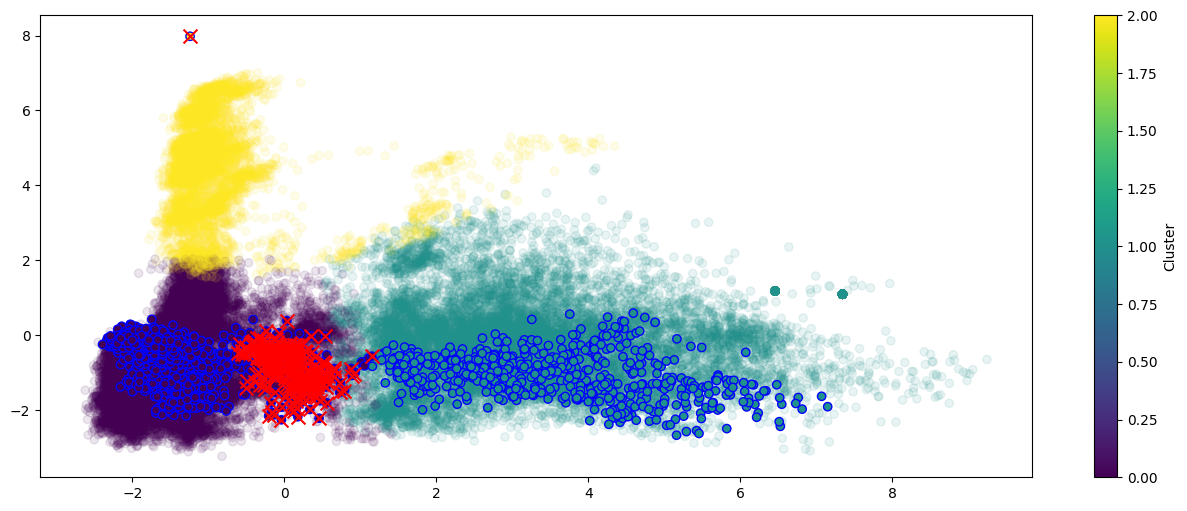

In [32]:
scaled_detected_data = scaler.transform(detected_data.drop(columns=['cluster', 'distance_to_cluster']))
pca_detected_data = pca.transform(scaled_detected_data)


plt.figure(figsize=(16,6))
train_scatter = plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c=train_clusters, cmap='viridis', edgecolors=None, alpha=1)
train_scatter.set_alpha(0.1)

plt.scatter(pca_anomaly_data[:, 0], pca_anomaly_data[:, 1], c=anomalous_clusters, cmap='viridis', edgecolors='blue')
plt.colorbar(label='Cluster')

plt.scatter(pca_detected_data[:, 0], pca_detected_data[:, 1], color='red', marker='x', alpha=1, s=100)


plt.show()